Take in athlete PR
Convert to percentage of world record
Create other expected perfomances for different races
Plot on graph
Take GAP of Segment
Plot gap on graph, see if over or under curve

In [4]:
import datetime
WR_800 = datetime.timedelta(minutes=1,seconds=40)
WR_MILE = datetime.timedelta(minutes=3,seconds=43)
WR_2K = datetime.timedelta(minutes=4,seconds=44) 
WR_3K = datetime.timedelta(minutes=7,seconds=20)
WR_5K = datetime.timedelta(minutes=12,seconds=35)
WR_10K = datetime.timedelta(minutes=26,seconds=24)
WR_10M = datetime.timedelta(minutes=44,seconds=24)
WR_MARATHON = datetime.timedelta(hours=2,minutes=1,seconds=39)

def pr_to_wr_percentage(athlete_pr:datetime.time):  
    return WR_5K.total_seconds() / athlete_pr.total_seconds()

def get_equivalent_time_all_records(wr_percentage):
    rigels_constant = 1 # helps with accuracy
    t_0 = 0
    t_800 = WR_800.total_seconds() + (WR_800.total_seconds() * (1-wr_percentage)) * rigels_constant
    t_mile = WR_MILE.total_seconds() + (WR_MILE.total_seconds() * (1-wr_percentage))* rigels_constant
    t_2k = WR_2K.total_seconds() + (WR_2K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_3k = WR_3K.total_seconds() + (WR_3K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_5k = WR_5K.total_seconds() + (WR_5K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10k = WR_10K.total_seconds() + (WR_10K.total_seconds() * (1-wr_percentage))* rigels_constant
    t_10m = WR_10M.total_seconds() + (WR_10M.total_seconds() * (1-wr_percentage))* rigels_constant
    t_mara = WR_MARATHON.total_seconds() + (WR_MARATHON.total_seconds() * (1-wr_percentage))* rigels_constant
    return t_0,t_800,t_mile,t_2k,t_3k,t_5k,t_10k,t_10m,t_mara


In [5]:
pr = datetime.timedelta(minutes=14,seconds=46)
percentage = pr_to_wr_percentage(pr)

In [6]:
print(get_equivalent_time_all_records(percentage))

(0, 115.6726862302483, 257.95009029345374, 328.5104288939052, 508.95981941309253, 873.3287810383747, 1832.2553498871332, 3081.520361173815, 8442.949367945825)


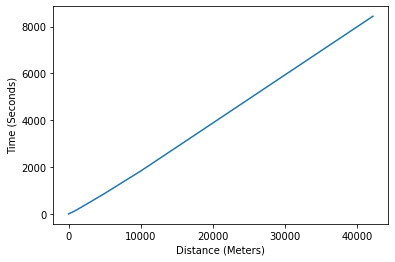

In [7]:
from matplotlib import pyplot as plt
distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
def graph_distance_v_time(equivalent_event_times):
    meters = distances
    time = equivalent_event_times
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plt.plot(meters,time)
    plt.show()
    return meters,time
    

plot_data = graph_distance_v_time(get_equivalent_time_all_records(percentage))


In [8]:
# Gap is 10s per 44ft per 1609.34m
# So GAP pace change = -10 * ((elevation gain/drop/#miles) * (#miles)/44) 
# In meteres = -10 * ((elevation gain/drop/(distance/1609.44)) * ((distance/1609.4)/44) 
# Break down a run into 10m stretches
# GAP is 10/160.09 seconds per 44/160.09 ft gain/drop per 10m
# So for a 10m run in 

In [9]:
def calc_GAP(distance,time,elevation_gain):
    # presume distance in meterss and elevation_gain in meters
    meters_to_miles_conversion = 1/1609.44
    ft_to_meters_conversion = 1/3.281
    pace = time/distance
    GAP_addition = -10 * (elevation_gain/(distance*meters_to_miles_conversion)) * ((distance*meters_to_miles_conversion)/(44*ft_to_meters_conversion)) 
    GAP = pace + GAP_addition/1609.44
    return GAP



In [86]:
import numpy as np
def calc_pace_for_segment(plot_data,segment_data):
    athlete_time = np.interp(segment_data[0],plot_data[0],plot_data[1])
    
    athlete_pace = athlete_time/(segment_data[0]/1000) # pace in seconds/km
    segment_pace =  segment_data[1]/(segment_data[0]/1000) # pace in seconds/km
    return str(datetime.timedelta(seconds=athlete_pace)),str(datetime.timedelta(seconds=segment_pace))

In [78]:
# Need to determine whether a point is above or below graph line
def graph_segment_on_athlete_curve(plot_data,segment_data,segment_name):
    plt.xlabel("Distance (Meters)")
    plt.ylabel("Time (Seconds)")
    plot_x_nearest_to_segment = min(plot_data[0], key=lambda x:abs(x-segment_data[0]))
    plot_y_nearest_to_segment = min(plot_data[1], key=lambda x:abs(x-segment_data[1]))
    # find a good axis window
    axis_range = 1000
    plt.axis([segment_data[0]-axis_range,segment_data[0]+axis_range,
    min(plot_x_nearest_to_segment,segment_data[1]-axis_range),max(plot_y_nearest_to_segment,segment_data[1]+axis_range)])
    plt.scatter([segment_data[0]],[segment_data[1]],color="red",label=f"{segment_name} Segment")
    plt.plot(plot_data[0],plot_data[1],label="Athlete")
    plt.legend()
    plt.show()

    # calculate the paces for each
    athlete_pace,segment_pace = calc_pace_for_segment(plot_data,segment_data)
    print(f"Athlete pace: {athlete_pace} km/s")
    print(f"Segment pace: {segment_pace} km/s")


def calc_above_or_below_plt_line(plot_data,segment_data):
    # Calculate cross product
    xA = segment_data[0]
    yA = segment_data[1]
    x1 = 0
    x2 = 0
    y1 = 0
    y2 = 0
    for distance_index in range(len(plot_data[0])):
        if plot_data[0][distance_index] > xA:
            x1 = plot_data[0][distance_index]
            y1 = plot_data[1][distance_index]
            x2 = plot_data[0][distance_index-1]
            y2 = plot_data[1][distance_index-1]
            break
    v1 = (x2-x1, y2-y1)   
    v2 = (x2-xA, y2-yA)   
    cross_product = v1[0]*v2[1] - v1[1]*v2[0] 
    if cross_product > 0:
        print('Athlete is faster than segment')
    elif cross_product < 0:
        print('Athlete is slower than segment')
    else:
        print('Athlete is exactly as fast as segment')
        


In [31]:
import json
import datetime
def get_segment_data_from_file(filename,segment_id):
        with open(filename,"r") as file:
                segment_data_dict = json.load(file)
        return segment_data_dict[segment_id]

def convert_segment_data_to_floats(segment_data:list):
        meters = float(segment_data[0][:-2])*1000
        hours_10s  = int(segment_data[1][-8]) if len(segment_data[1]) > 7 else 0
        hours_1s  = int(segment_data[1][-7]) if len(segment_data[1]) > 6 else 0
        mins_10s =  int(segment_data[1][-5]) if len(segment_data[1]) > 4 else 0
        mins_1s  = int(segment_data[1][-4]) if len(segment_data[1]) > 3 else 0
        seconds_10s = int(segment_data[1][-2]) if len(segment_data[1]) > 1 else 0
        seconds_1s = int(segment_data[1][-1]) if len(segment_data[1]) > 0 else 0
        total_seconds = (36000*hours_10s)+(3600*hours_1s)+(600*mins_10s)+(60*mins_1s)+ (10*seconds_10s) + seconds_1s
        evelation_gain = int(segment_data[2][:-1])
        return meters,total_seconds,evelation_gain


In [32]:

segment_data = get_segment_data_from_file("data/scraped_segment_data.json","1439652")
print(segment_data)
distance,time,gain = convert_segment_data_to_floats(segment_data)
print(distance,time,gain)
grade_adjusted_time = calc_GAP(distance,time,gain) * distance
print(grade_adjusted_time)




['1.88km', '5:40', '4m']
1880.0 340 4
336.5158519281693


Athlete is faster than segment


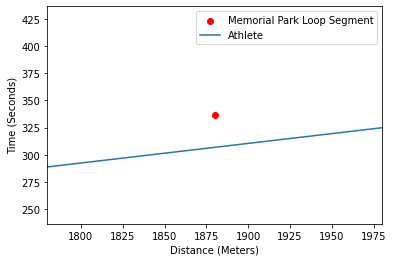

Athlete pace: 0:02:38.567084 km/s
Segment pace: 0:02:58.997794 km/s


In [46]:
segment_data = (distance,grade_adjusted_time) # distance,time
calc_above_or_below_plt_line(plot_data,segment_data)
graph_segment_on_athlete_curve(plot_data,segment_data,"Memorial Park Loop")

# GAP 1.0 conclusions


In [14]:
# pr given as timedelta object
def get_athlete_vs_segment(athlete_5k_pr,segment_id,segment_name):
    #pr = datetime.timedelta(minutes=14,seconds=46)
    percentage = pr_to_wr_percentage(pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = get_segment_data_from_file("data/scraped_segment_data.json",segment_id)
    print(segment_data)
    distance,time,gain = convert_segment_data_to_floats(segment_data)
    grade_adjusted_time = calc_GAP(distance,time,gain) * distance
    print(time)
    print(grade_adjusted_time)
    segment_data = (distance,grade_adjusted_time) # distance,time
    calc_above_or_below_plt_line((distances,equivalent_times),segment_data)
    graph_segment_on_athlete_curve((distances,equivalent_times),segment_data,segment_name)
    

['4.96km', '15:16', '38m']
916
828.6739057741146
Athlete is slower than segment
[    0.     800.    1609.    2000.    3000.    5000.   10000.   16093.4
 42164.81]
[   0.          115.67268623  257.95009029  328.51042889  508.95981941
  873.32878104 1832.25534989 3081.52036117 8442.94936795]


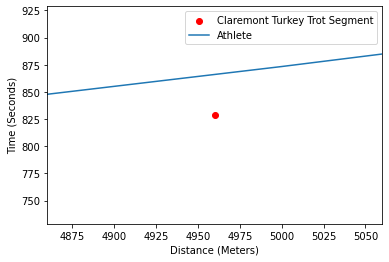

In [25]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "6105319"
segment_name = "Claremont Turkey Trot"
get_athlete_vs_segment(pr,segment_id,segment_name)


# Conclusions:
Looks like this GAP formula is pretty agressive. I think it probably works better for larger elevations, but it seems unfair to drop 30s per mile on a 3 mile run with 132ft gain. I think I'll need to find a way to find tune this model

# GAP Equation 2.0
This equation says that for every 1% grade in elevation, there is a 12-15s decrease per mile
In km's that 7.46-9.32s

In [16]:
# TODO Am i accounting for negative grade? I am not, this needs to change
# returns an upper and lower bound for GAP
def calc_GAP_2(distance,time,elevation_gain):
    grade = (elevation_gain/distance) * 100
    grade_adjusted_time_low = time - ((grade * 7.46/1000) * distance)  
    grade_adjusted_time_high = time - ((grade * 9.32/1000) * distance)
    return grade_adjusted_time_low,grade_adjusted_time_high

In [17]:
# pr given as timedelta object
def get_athlete_vs_segment_v2(athlete_5k_pr,segment_id,segment_name):
    #pr = datetime.timedelta(minutes=14,seconds=46)
    percentage = pr_to_wr_percentage(pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = get_segment_data_from_file("data/scraped_segment_data.json",segment_id)
    print(f"Segment data: {segment_data}")
    distance,time,gain = convert_segment_data_to_floats(segment_data)
    grade_adjusted_time,time2 = calc_GAP_2(distance,time,gain)
    print(f"Seconds: {time}")
    print(f"Grade Adjusted Seconds {grade_adjusted_time}")
    print(f"Time reduction {time-grade_adjusted_time}")
    segment_data = (distance,grade_adjusted_time) # distance,time
    calc_above_or_below_plt_line((distances,equivalent_times),segment_data)
    graph_segment_on_athlete_curve((distances,equivalent_times),segment_data,segment_name)

Segment data: ['6.25km', '18:22', '66m']
Seconds: 1102
Grade Adjusted Seconds 1052.764
Time reduction 49.236000000000104
Athlete is slower than segment


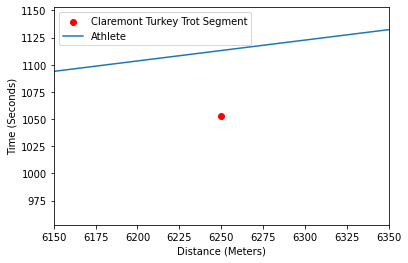

In [18]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "2588795"
segment_name = "Claremont Turkey Trot"
get_athlete_vs_segment_v2(pr,segment_id,segment_name)

# Putting it all together
On demand find a segment and see if an athlete can get it

In [69]:

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By

def get_segment_distance_time_grade(segment_id):
    driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')
    url = f"https://www.strava.com/segments/{segment_id}?filter=overall"
    driver.get(url)
    #login_to_strava()
    distance_element = driver.find_element(By.XPATH,'//*[@id="segment"]/div/div[3]/ul/li[1]/div/b')
    grade_element = driver.find_element(By.XPATH,'//*[@id="segment"]/div/div[3]/ul/li[3]/div/b')
    try:
        # check if there is a VAM
         leader_time_element = driver.find_element(By.XPATH,'//*[@id="segment-leaderboard"]/div/table/tbody/tr[1]/td[5]')
    except Exception:
         leader_time_element = driver.find_element(By.XPATH,'//*[@id="segment-leaderboard"]/div/table/tbody/tr[1]/td[4]')
    
    return distance_element.text,leader_time_element.text,grade_element.text


In [64]:
def convert_segment_data_to_floats_v2(segment_data:list):
        # remove all commas
        new_segment_data = []
        for data in segment_data:
                new_segment_data.append(data.replace(",",""))
        segment_data = new_segment_data
        
        meters = float(segment_data[0][:-2])*1000
        hours_10s  = int(segment_data[1][-8]) if len(segment_data[1]) > 7 else 0
        hours_1s  = int(segment_data[1][-7]) if len(segment_data[1]) > 6 else 0
        mins_10s =  int(segment_data[1][-5]) if len(segment_data[1]) > 4 else 0
        mins_1s  = int(segment_data[1][-4]) if len(segment_data[1]) > 3 else 0
        seconds_10s = int(segment_data[1][-2]) if len(segment_data[1]) > 1 else 0
        seconds_1s = int(segment_data[1][-1]) if len(segment_data[1]) > 0 else 0
        total_seconds = (36000*hours_10s)+(3600*hours_1s)+(600*mins_10s)+(60*mins_1s)+ (10*seconds_10s) + seconds_1s
        avg_grade = float(segment_data[2][:-1])
        return meters,total_seconds,avg_grade

In [21]:
def gap_v2_with_grade(distance,time,grade):
    if grade < 0:
        grade_adjusted_time_low = time - ((grade * 4.97/1000) * distance)  
        grade_adjusted_time_high = grade_adjusted_time_low
    else:
        grade_adjusted_time_low = time - ((grade * 7.46/1000) * distance)  
        grade_adjusted_time_high = time - ((grade * 9.32/1000) * distance)
    return grade_adjusted_time_low,grade_adjusted_time_high
    

In [22]:
def get_athlete_v_segment(pr_5k,segment_id,segment_name=""):
    # get segment data
    distance,time,grade = get_segment_distance_time_grade(segment_id)
    distance,time,grade = convert_segment_data_to_floats_v2([distance,time,grade])
    grade_adjusted_time_low,grade_adjusted_time_high = gap_v2_with_grade(distance,time,grade)
    # get athlete data
    percentage = pr_to_wr_percentage(pr)
    equivalent_times = get_equivalent_time_all_records(percentage)
    # graph both
    plot_distances = [0,800,1609,2000,3000,5000,10000,16093.4,42164.81]
    segment_data = (distance,grade_adjusted_time_low)
    calc_above_or_below_plt_line((plot_distances,equivalent_times),segment_data)
    graph_segment_on_athlete_curve((plot_distances,equivalent_times),segment_data,segment_name)  

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


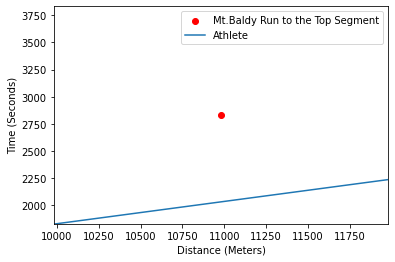

Athlete pace: 0:03:05.170704 km/s
Segment pace: 0:04:17.861454 km/s


In [89]:
import datetime
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "2298308"
segment_name = "Mt.Baldy Run to the Top"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


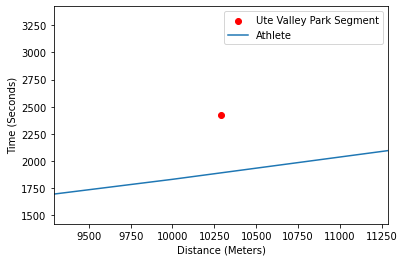

Athlete pace: 0:03:03.839744 km/s
Segment pace: 0:03:55.482423 km/s


In [90]:
segment_id = "27001396"
segment_name = "Ute Valley Park"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


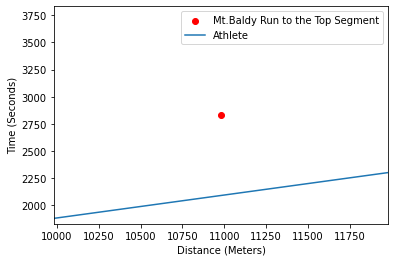

Athlete pace: 0:03:10.514522 km/s
Segment pace: 0:04:17.861454 km/s


In [88]:
# Lets see if walt can get it 
pr = datetime.timedelta(minutes=15,seconds=20)
segment_id = "2298308"
segment_name = "Mt.Baldy Run to the Top"
get_athlete_v_segment(pr,segment_id,segment_name)

C:\Users\James\AppData\Local\Temp\ipykernel_27920\2936833739.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('/Users/James/Downloads/chromedriver')


Athlete is faster than segment


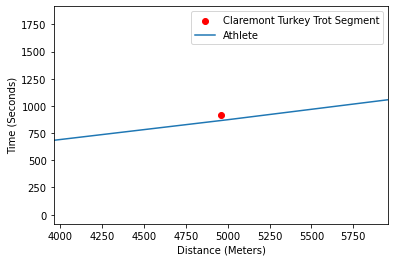

Athlete pace: 0:02:54.605121 km/s
Segment pace: 0:03:04.677419 km/s


In [95]:
pr = datetime.timedelta(minutes=14,seconds=46)
segment_id = "6105319"
segment_name = "Claremont Turkey Trot"
get_athlete_v_segment(pr,segment_id,segment_name)